# Deep learning meets missing data: Doing it MIWAE

In this notebook, we'll show how to learn a deep generative model on a small and **incomplete** continuous data set. We will also show how to **impute** the missing values of this data set. 

This is based on the following paper, available [on arXiv](https://arxiv.org/abs/1812.02633):

P.-A. Mattei & J. Frellsen, **MIWAE: Deep Generative Modelling and Imputation of Incomplete Data Sets**, *Proceedings of the 36th International Conference on Machine Learning*, PMLR 97:4413-4423, 2019.

It is possible to run this notebook in Google Colab, which allows to benefit from free GPU computing.
<table class="tfo-notebook-buttons" align="left">
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/pamattei/MIWAE_Pytorch_exercises_demo_ProbAI.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


# Installing and loading useful stuff

In [1]:
!pip3 install --user --upgrade scikit-learn # We need to update it to run missForest

import torch
import torchvision
import torch.nn as nn
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.2)


In [0]:
def mse(xhat,xtrue,mask): # MSE function for imputations
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.mean(np.power(xhat-xtrue,2)[~mask])

# Loading the data

We'll use the Iris data set from scikit-learn:



In [0]:
from sklearn.datasets import load_iris
data = load_iris(True)[0]

It is also possible to use the breast cancer or the Boston data sets by uncommenting one of the following cells:

In [0]:
#from sklearn.datasets import load_breast_cancer
#data = load_breast_cancer(True)[0]

In [0]:
#from sklearn.datasets import load_boston
#data = load_boston(True)[0]

It is also possible to use the "white wine" or "red wine" UCI data sets by uncommenting one of the following cells:



In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';'))

In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';'))

In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
#data = np.array(pd.read_csv(url, low_memory=False, sep=','))[:,0:4]

In [0]:
xfull = (data - np.mean(data,0))/np.std(data,0)
n = xfull.shape[0] # number of observations
p = xfull.shape[1] # number of features

We will remove uniformy at random 50% of the data. This corresponds to a *missing completely at random (MCAR)* scenario.

In [0]:
np.random.seed(1234)

perc_miss = 0.5 # 50% of missing data
xmiss = np.copy(xfull)
xmiss_flat = xmiss.flatten()
miss_pattern = np.random.choice(n*p, np.floor(n*p*perc_miss).astype(np.int), replace=False)
xmiss_flat[miss_pattern] = np.nan 
xmiss = xmiss_flat.reshape([n,p]) # in xmiss, the missing values are represented by nans
mask = np.isfinite(xmiss) # binary mask that indicates which values are missing

A simple way of imputing the incomplete data is to replace the missing values by zeros. This x_hat0 is what will be fed to our encoder.

In [0]:
xhat_0 = np.copy(xmiss)
xhat_0[np.isnan(xmiss)] = 0

# Hyperparameters

In [0]:
h = 128 # number of hidden units in (same for all MLPs)
d = 1 # dimension of the latent space
K = 20 # number of IS during training


# Model building

We will use a **deep latent variable model with a Gaussian prior and a Student's t observation model**. This can be written:

$$p(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p(\mathbf{x}_i|\mathbf{z}_i) = \text{St} (\mathbf{x}_i|\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$ are functions parametrised by deep neural nets.

The weights of these nets are stored in a parameter $\boldsymbol{\theta}$. We choose to use the following simple architecture, where the 3 neural nets share the first layers:
$$f_{\boldsymbol{\theta}} (\mathbf{z})=\sigma(\mathbf{W}_1\sigma(\mathbf{W}_0\mathbf{z}+\mathbf{b}_0)+\mathbf{b}_1) $$

$$\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{W}_\boldsymbol{\mu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\mu}, $$

$$\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Diag}\left(\text{Softplus}(\mathbf{W}_\boldsymbol{\sigma}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\sigma}) + 10^{-3}\right), $$

$$\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Softplus}(\mathbf{W}_\boldsymbol{\nu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\nu}) + 3. $$

A few **non-essential remarks** about this architecture:

* This parametrisation is quite close to the one we use in the MIWAE paper. The main difference is that we use $\sigma = \text{ReLU}$ (which leads to faster training) while we used $\sigma = \text{tanh}$ in the paper.
*   We use a [location-scale parametrisation](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) of the t distribution, following [the parametrisation available in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/distributions/StudentT). Note in particular that $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ is not the covariance matrix of $\mathbf{x} | \mathbf{z}$. When it exitsts, the actual covariance matrix is diagonal with diagonal  $$ \frac{\text{diag}(\boldsymbol{\Sigma}_{\boldsymbol{\theta}} (\mathbf{z}))^2 \boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})}{\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})-2}$$ (where all operations are made entrywise).
*   The fact that the covariance matrix is diagonal means that we assume that **the features are independent conditionnally on the latent variable** (which is customary for DLVMs).
* We add $3$ to the neural net that outputs the degrees of freedom. This is to guarantee that the tails of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are not too heavy. Indeed, having too heavy tails might imply that the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ does not exist! Adding 3 implies that the degrees of freedom is always larger than 3, implying in turn that **at least the first 3 moments of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are well-defined.**
* We add $10^{-3}$ to the diagonal entries of $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}$ to prevent singularities, [as advocated in our NeurIPS 2018 paper](https://papers.nips.cc/paper/7642-leveraging-the-exact-likelihood-of-deep-latent-variable-models). Why $10^{-3}$ specifically? Because, since the data have unit variance, this will imply that the latent variable explains at most $99.9999\%$ of the variance of the data, which does not seem too restrictive. **This choice might be poor if the data are not standardised.**




We begin with the prior:

In [0]:
p_z = td.Independent(td.Normal(loc=torch.zeros(d).cuda(),scale=torch.ones(d).cuda()),1)

 Now, we define the **decoder**, which will be the backbone of the three functions $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$. Here, the output space of this decoder is $\mathbb{R}^{3p}$. Some additional operations are needed for $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$, but it'll be more convenient to implement them later.

In [0]:
decoder = nn.Sequential(
    torch.nn.Linear(d, h),
    torch.nn.ReLU(),
    torch.nn.Linear(h, h),
    torch.nn.ReLU(),
    torch.nn.Linear(h, 3*p),  # the decoder will output both the mean, the scale, and the number of degrees of freedoms (hence the 3*p)
)

# Posterior approximation

We will build a Gaussian posterior approximation $q(\mathbf{z}|\mathbf{x}) = \mathcal{N} (\mathbf{z}|\mathbf{m}_\gamma (\mathbf{x}),\mathbf{S}_\gamma (\mathbf{x}))$ by using an **encoder** that mimicks the architecture of the decoder.

In [0]:
encoder = nn.Sequential(
    torch.nn.Linear(p, h),
    torch.nn.ReLU(),
    torch.nn.Linear(h, h),
    torch.nn.ReLU(),
    torch.nn.Linear(h, 2*d),  # the encoder will output both the mean and the diagonal covariance
)

In [16]:
encoder.cuda() # we'll use the GPU
decoder.cuda()

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=12, bias=True)
)

# Building the MIWAE loss

We will define a function that, given the imputation $\iota(\mathbf{x}^\text{o})$ and the mask, computes the MIWAE bound.

$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^\text{o}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i^\text{o}|\mathbf{z}_{ik})p(\mathbf{z}_{ik})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}^\text{o}_i)} \right].
$$

In [0]:
def miwae_loss(iota_x,mask):
  batch_size = iota_x.shape[0]
  out_encoder = encoder(iota_x)
  q_zgivenxobs = td.Independent(td.Normal(loc=out_encoder[..., :d],scale=torch.nn.Softplus()(out_encoder[..., d:(2*d)])),1)
  
  zgivenx = q_zgivenxobs.rsample([K])
  zgivenx_flat = zgivenx.reshape([K*batch_size,d])
  
  out_decoder = decoder(zgivenx_flat)
  all_means_obs_model = out_decoder[..., :p]
  all_scales_obs_model = torch.nn.Softplus()(out_decoder[..., p:(2*p)]) + 0.001
  all_degfreedom_obs_model = torch.nn.Softplus()(out_decoder[..., (2*p):(3*p)]) + 3
  
  data_flat = torch.Tensor.repeat(iota_x,[K,1]).reshape([-1,1])
  tiledmask = torch.Tensor.repeat(mask,[K,1])
  
  all_log_pxgivenz_flat = torch.distributions.StudentT(loc=all_means_obs_model.reshape([-1,1]),scale=all_scales_obs_model.reshape([-1,1]),df=all_degfreedom_obs_model.reshape([-1,1])).log_prob(data_flat)
  all_log_pxgivenz = all_log_pxgivenz_flat.reshape([K*batch_size,p])
  
  logpxobsgivenz = torch.sum(all_log_pxgivenz*tiledmask,1).reshape([K,batch_size])
  logpz = p_z.log_prob(zgivenx)
  logq = q_zgivenxobs.log_prob(zgivenx)
  
  neg_bound = -torch.mean(torch.logsumexp(logpxobsgivenz + logpz - logq,0))
  
  return neg_bound

In [0]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=1e-3)

# Single imputation

We can do single imputation using self normalised IS:
\begin{equation*}
\mathbb E [\mathbf{x}^{\textrm{m}} | \mathbf{x}^{\textrm{o}}] \approx \sum_{l=1}^L w_l \, \mathbf{x}^{\textrm{m}}_{(l)},
\end{equation*}
where $(\mathbf{x}^{\textrm{m}}_{(1)},\mathbf{z}_{(1)}),\ldots,(\mathbf{x}^{\textrm{m}}_{(L)},\mathbf{z}_{(L)})$ are i.i.d.~samples from $p_{\boldsymbol{\theta}}(\mathbf{x}^{\textrm{m}}|\mathbf{x}^{\textrm{o}},\mathbf{z})q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^{\textrm{o}})$ and 
\begin{equation*}
w_l=\frac{r_l}{r_1+\ldots+r_L}, \; \textrm{with} \; r_l = \frac{p_{\boldsymbol{\theta}}(\mathbf{x}^{\textrm{o}}|\mathbf{z}_{(l)})p(\mathbf{z}_{(l)})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{(l)}|\mathbf{x}^{\textrm{o}})}.
\end{equation*}

In [0]:
def miwae_impute(iota_x,mask,L):
  batch_size = iota_x.shape[0]
  out_encoder = encoder(iota_x)
  q_zgivenxobs = td.Independent(td.Normal(loc=out_encoder[..., :d],scale=torch.nn.Softplus()(out_encoder[..., d:(2*d)])),1)
  
  zgivenx = q_zgivenxobs.rsample([L])
  zgivenx_flat = zgivenx.reshape([L*batch_size,d])
  
  out_decoder = decoder(zgivenx_flat)
  all_means_obs_model = out_decoder[..., :p]
  all_scales_obs_model = torch.nn.Softplus()(out_decoder[..., p:(2*p)]) + 0.001
  all_degfreedom_obs_model = torch.nn.Softplus()(out_decoder[..., (2*p):(3*p)]) + 3
  
  data_flat = torch.Tensor.repeat(iota_x,[L,1]).reshape([-1,1]).cuda()
  tiledmask = torch.Tensor.repeat(mask,[L,1]).cuda()
  
  all_log_pxgivenz_flat = torch.distributions.StudentT(loc=all_means_obs_model.reshape([-1,1]),scale=all_scales_obs_model.reshape([-1,1]),df=all_degfreedom_obs_model.reshape([-1,1])).log_prob(data_flat)
  all_log_pxgivenz = all_log_pxgivenz_flat.reshape([L*batch_size,p])
  
  logpxobsgivenz = torch.sum(all_log_pxgivenz*tiledmask,1).reshape([L,batch_size])
  logpz = p_z.log_prob(zgivenx)
  logq = q_zgivenxobs.log_prob(zgivenx)
  
  xgivenz = td.Independent(td.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model),1)

  imp_weights = torch.nn.functional.softmax(logpxobsgivenz + logpz - logq,0) # these are w_1,....,w_L for all observations in the batch
  xms = xgivenz.sample().reshape([L,batch_size,p])
  xm=torch.einsum('ki,kij->ij', imp_weights, xms) 
  

  
  return xm

# Training

In [0]:
def weights_init(layer):
  if type(layer) == nn.Linear: torch.nn.init.orthogonal_(layer.weight)
   

In [21]:
miwae_loss_train=np.array([])
mse_train=np.array([])
mse_train2=np.array([])
bs = 64 # batch size
n_epochs = 2002
xhat = np.copy(xhat_0) # This will be out imputed data matrix

encoder.apply(weights_init)
decoder.apply(weights_init)

for ep in range(1,n_epochs):
  perm = np.random.permutation(n) # We use the "random reshuffling" version of SGD
  batches_data = np.array_split(xhat_0[perm,], n/bs)
  batches_mask = np.array_split(mask[perm,], n/bs)
  for it in range(len(batches_data)):
    optimizer.zero_grad()
    encoder.zero_grad()
    decoder.zero_grad()
    b_data = torch.from_numpy(batches_data[it]).float().cuda()
    b_mask = torch.from_numpy(batches_mask[it]).float().cuda()
    loss = miwae_loss(iota_x = b_data,mask = b_mask)
    loss.backward()
    optimizer.step()
  if ep % 100 == 1:
    print('Epoch %g' %ep)
    print('MIWAE likelihood bound  %g' %(-np.log(K)-miwae_loss(iota_x = torch.from_numpy(xhat_0).float().cuda(),mask = torch.from_numpy(mask).float().cuda()).cpu().data.numpy())) # Gradient step      
    
    ### Now we do the imputation
    
    xhat[~mask] = miwae_impute(iota_x = torch.from_numpy(xhat_0).float().cuda(),mask = torch.from_numpy(mask).float().cuda(),L=10).cpu().data.numpy()[~mask]
    err = np.array([mse(xhat,xfull,mask)])
    mse_train = np.append(mse_train,err,axis=0)
    print('Imputation MSE  %g' %err)
    print('-----')

Epoch 1
MIWAE likelihood bound  -3.19261
Imputation MSE  1.19521
-----
Epoch 101
MIWAE likelihood bound  -1.80769
Imputation MSE  0.476078
-----
Epoch 201
MIWAE likelihood bound  -1.67583
Imputation MSE  0.479187
-----
Epoch 301
MIWAE likelihood bound  -1.54004
Imputation MSE  0.444001
-----
Epoch 401
MIWAE likelihood bound  -1.6617
Imputation MSE  0.516101
-----
Epoch 501
MIWAE likelihood bound  -1.51865
Imputation MSE  0.512431
-----
Epoch 601
MIWAE likelihood bound  -1.58895
Imputation MSE  0.496381
-----
Epoch 701
MIWAE likelihood bound  -1.63319
Imputation MSE  0.4554
-----
Epoch 801
MIWAE likelihood bound  -1.63603
Imputation MSE  0.446688
-----
Epoch 901
MIWAE likelihood bound  -1.4017
Imputation MSE  0.493753
-----
Epoch 1001
MIWAE likelihood bound  -1.45007
Imputation MSE  0.51599
-----
Epoch 1101
MIWAE likelihood bound  -1.42624
Imputation MSE  0.478521
-----
Epoch 1201
MIWAE likelihood bound  -1.40289
Imputation MSE  0.467798
-----
Epoch 1301
MIWAE likelihood bound  -1.51026

# Comparisons with other methods

We make use of the recent [IterativeImputer](https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html) mehod implemented in scikit-learn. It allows, in particular, to use an imputation technique quite similar to the popular missForest algorithm of  [Stekhoven & Bühlmann (2011)](https://academic.oup.com/bioinformatics/article/28/1/112/219101).

In [22]:
missforest = IterativeImputer(max_iter=20, estimator=ExtraTreesRegressor(n_estimators=100))
iterative_ridge = IterativeImputer(max_iter=20, estimator=BayesianRidge())
missforest.fit(xmiss)
iterative_ridge.fit(xmiss)
xhat_mf = missforest.transform(xmiss)
xhat_ridge = iterative_ridge.transform(xmiss)
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imp.fit(xmiss)
xhat_mean = mean_imp.transform(xmiss)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


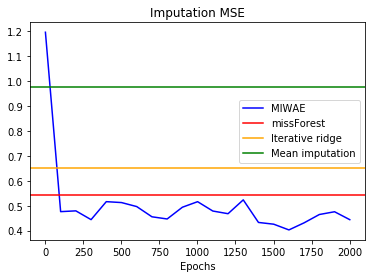

In [23]:
plt.plot(range(1,n_epochs,100),mse_train,color="blue")
plt.axhline(y=mse(xhat_mf,xfull,mask),  linestyle='-',color="red")
plt.axhline(y=mse(xhat_ridge,xfull,mask),  linestyle='-',color="orange")
plt.axhline(y=mse(xhat_mean,xfull,mask),  linestyle='-',color="green")
plt.legend(["MIWAE","missForest","Iterative ridge", "Mean imputation"])
plt.title("Imputation MSE")
plt.xlabel("Epochs")
plt.show()

# Exercise:

Try to come up with a better single imputation estimate, and implement it!